## EDA, Data Preprocessing and Data Engineering on WebTrafic dataset
### Total cumulative traffic per all devices

---

Time Series Forecasting with ARIMA, SARIMA and PROPHET on the Web Traffic dataset and forecasting the total cumulaive traffic per all devices. 

---
## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Time-series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

## Read the Dataset

In [2]:
df_org = pd.read_csv('clean_LA_web_traffic.csv',index_col=0, parse_dates=['Date']).reset_index(drop=True)
df_org

,Date,Device Category,Sessions
0,2014-01-01,desktop,1032805
1,2014-01-02,desktop,2359710
2,2014-01-03,desktop,2033439
3,2014-01-04,desktop,975623
4,2014-01-05,desktop,1237064
...,...,...,...
6190,2019-08-23,tablet,797
6191,2019-08-24,tablet,717
6192,2019-08-25,tablet,398
6193,2019-08-26,tablet,199


In [ ]:
# Grouping by date and summing the sessions across devices
df_total = df_org.groupby('Date').sum(numeric_only=True)
df_total

,Sessions
Date,
2014-01-01,1662852
2014-01-02,3192293
2014-01-03,2855860
2014-01-04,1806651
2014-01-05,1945606
...,...
2019-08-23,33576
2019-08-24,12915
2019-08-25,9664


## Exploratory Data Analysis

In [5]:
df_total.info()
print('\n\n')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2014-01-01 to 2019-08-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sessions  2065 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB





In [6]:
display(df_total.describe())

,Sessions
count,2.065000e+03
mean,2.789659e+06
std,1.513218e+06
min,1.075000e+03
25%,1.844087e+06
50%,2.850289e+06
75%,3.634547e+06
max,3.921783e+07


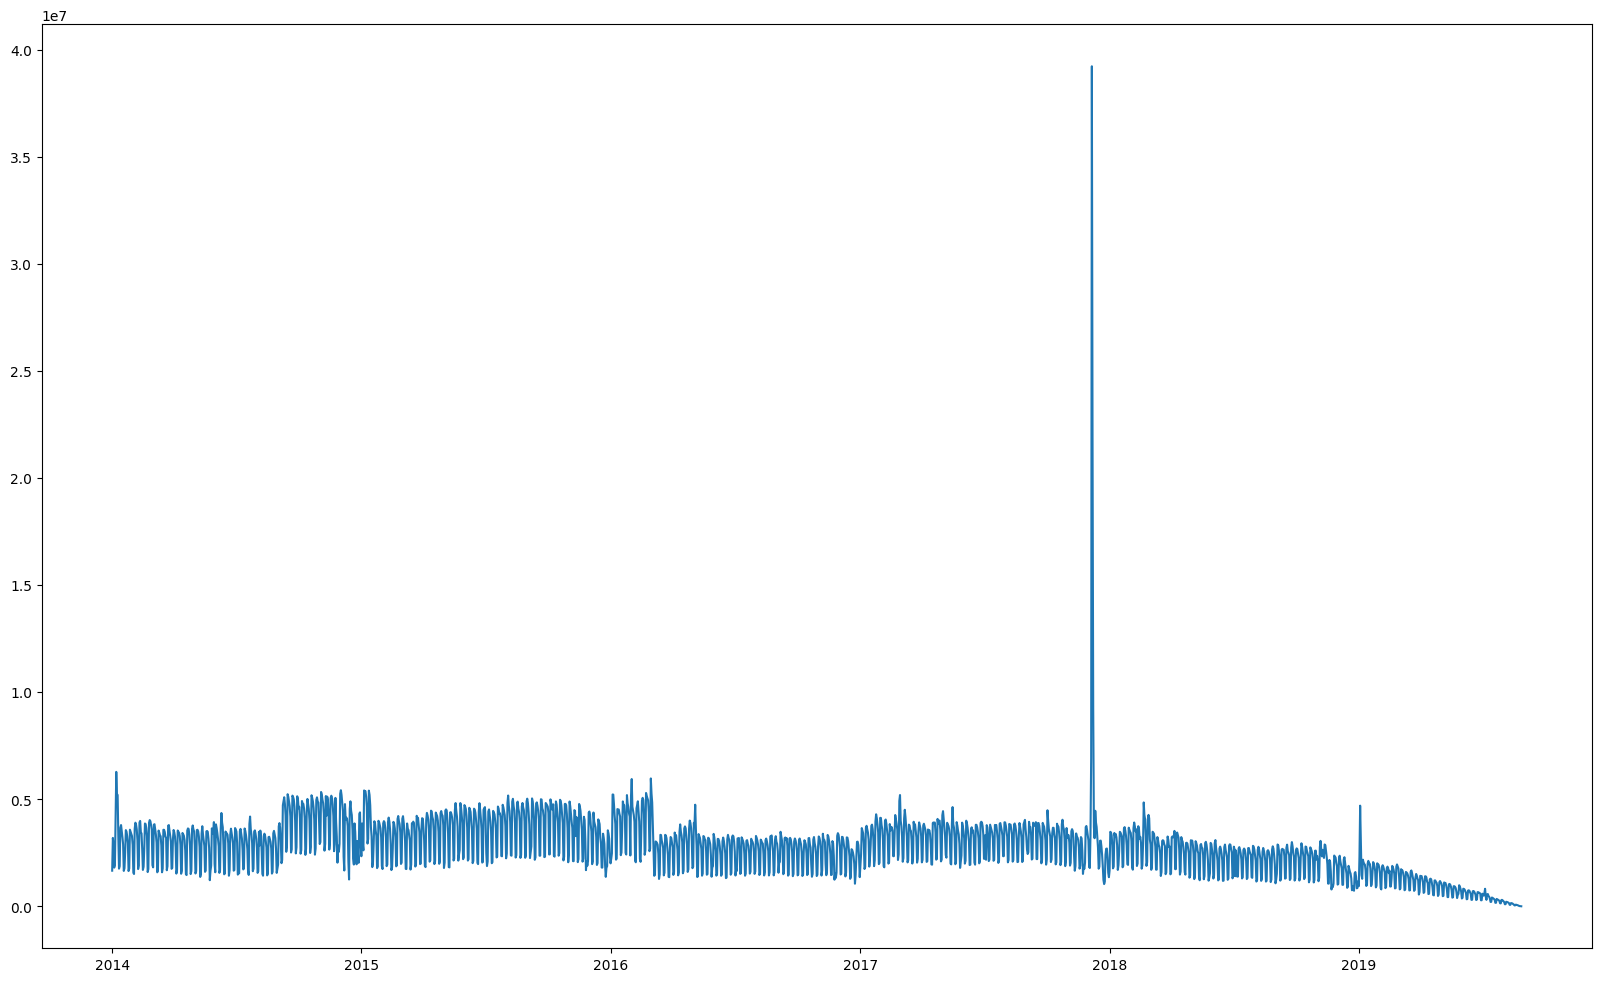

In [7]:
fig = plt.figure(figsize=(20,12))
plt.plot(df_total)
plt.show()

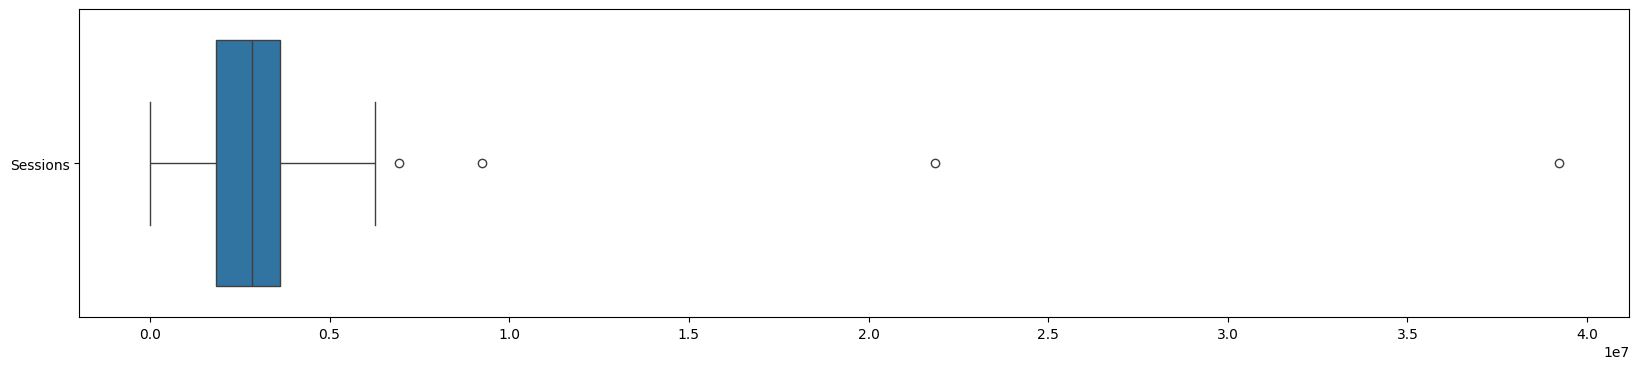

In [8]:
fig = plt.figure(figsize=(20,4))
sns.boxplot(df_total, orient='h')
plt.show()

---
## Handling Outliers 
### Removing the most extreme outliers and imputing them with mean value of the dataset
---

### Handling outliers for df_total

In [9]:
Q1 = np.percentile(df_total, 25)
Q3 = np.percentile(df_total, 75)
IQR = Q3 - Q1

L = Q1 - 1.5*IQR
U = Q3 + 1.5*IQR

df_total['Outlier'] = ((df_total['Sessions'] < L) | (df_total['Sessions'] > U))
df_total.loc[df_total['Outlier']==True]

,Sessions,Outlier
Date,,
2017-12-05,6934804,True
2017-12-06,39217826,True
2017-12-07,21842773,True
2017-12-08,9250668,True


In [10]:
#df_total.loc[df_total['Outlier'] == True].replace(df_total['Sessions'], df_total['Sessions'].mean())

mean_sessions = df_total.loc[df_total['Outlier'] == False, 'Sessions'].mean()
df_total.loc[df_total['Outlier'] == True, 'Sessions'] = mean_sessions

df_total = df_total.drop(columns=['Outlier'])

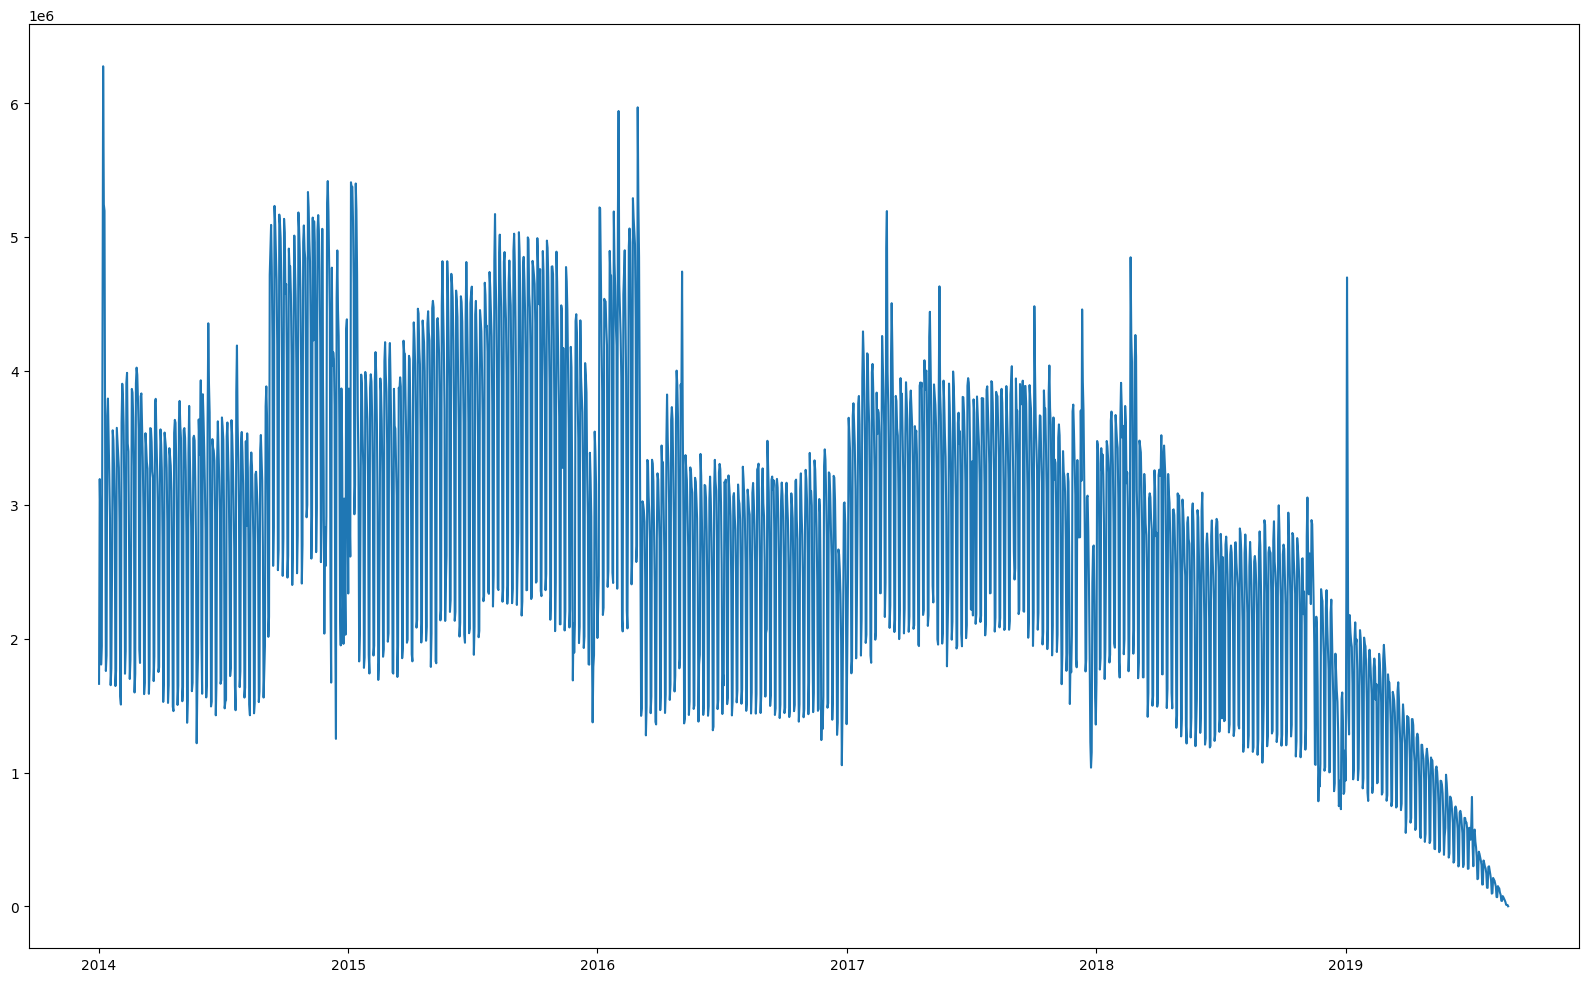

In [11]:
fig = plt.figure(figsize=(20,12))
plt.plot(df_total)
plt.show()

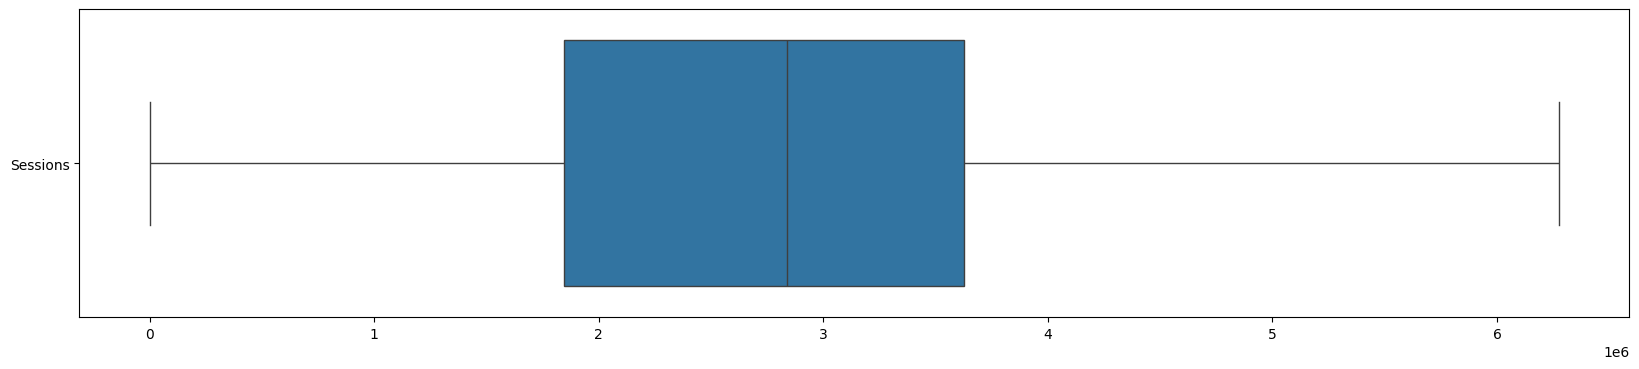

In [12]:
fig = plt.figure(figsize=(20,4))
sns.boxplot(df_total, orient='h')
plt.show()

**Conslusion**:       
The most extreme 4 outliers, visible as peaks in the plot, were deleted. 
They were then imputed using the mean value of the dataset to maintain consistency.
    
**Note**:       
Time series data does not typically work well with missing values, as gaps can disrupt the temporal structure and patterns in the data.
Proper imputation methods or interpolation should be used for time series analysis. 


---
# Stationarity tests

### Decomposition and Stationarity test for df_total

In [13]:
decomp = seasonal_decompose(df_total['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable: "Sessions"


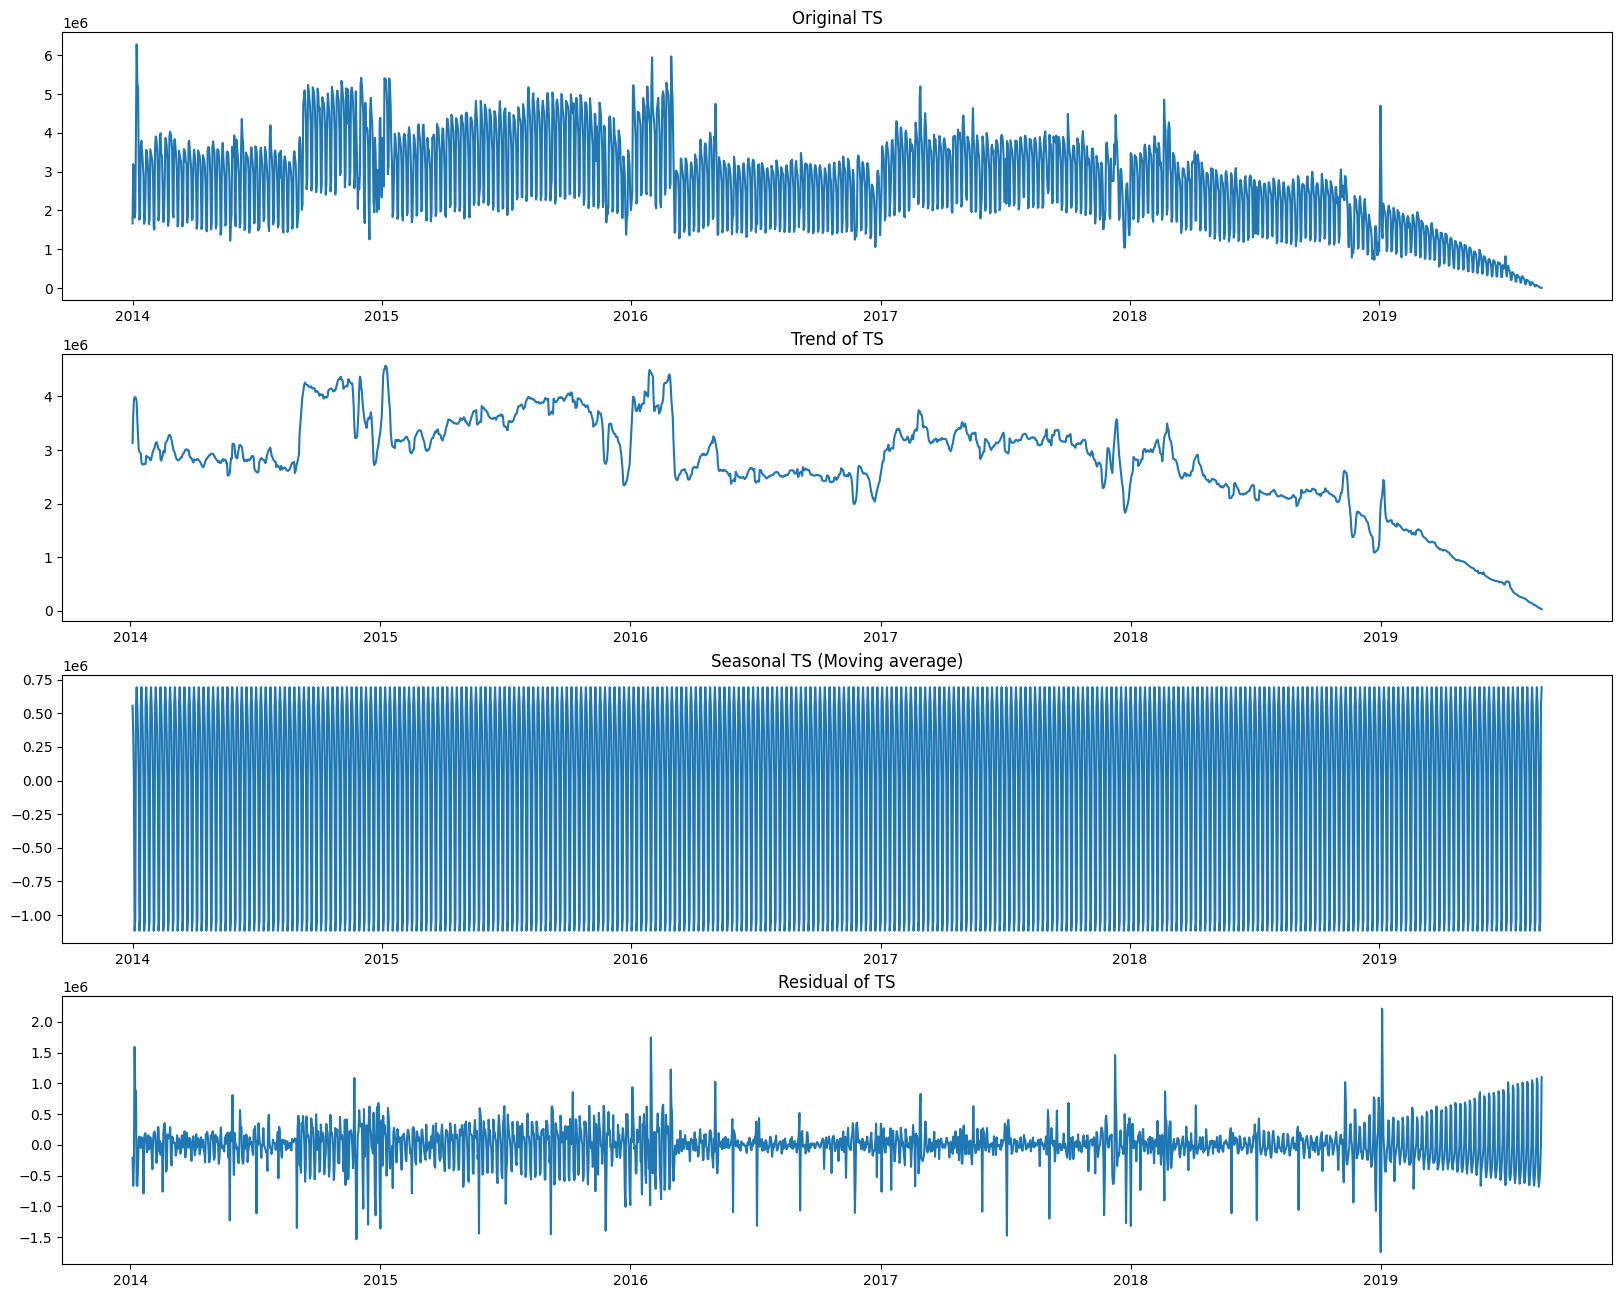

In [14]:
fig = plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df_total['Sessions'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable: "Sessions"')

## Decomposition of the endogenous variable

**Trend Component**: Does not show persistent increasing or decreasing direction in the data.

**Seasonal Component**: This component captures regular patterns that occur over a period of 7 days.

**Residual Component**: This component represents the remaining random fluctuations in the data after removing the trend and seasonal components. Nothing particular can be seen at this point.

Text(0.5, 1.0, 'Original TS')

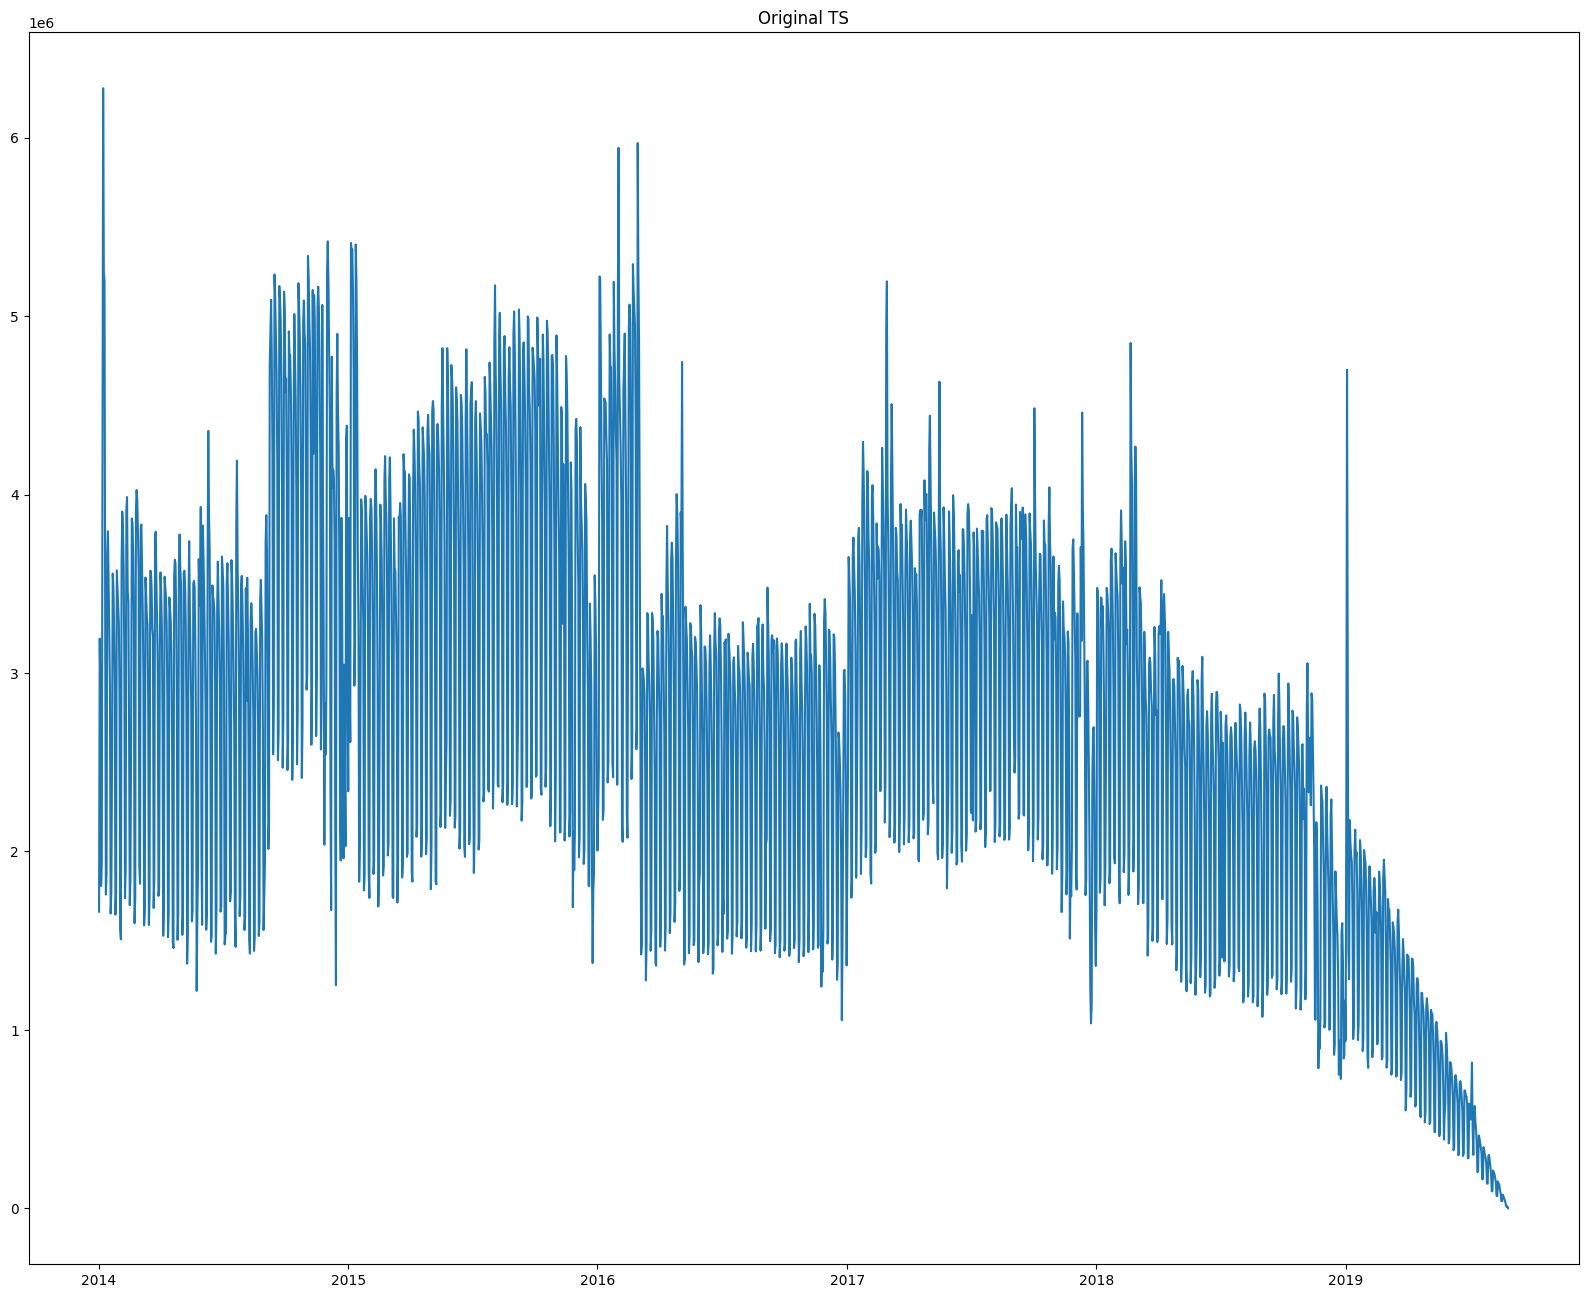

In [15]:
fig = plt.figure(figsize=(20,16))
plt.plot(df_total['Sessions'])
plt.title('Original TS')

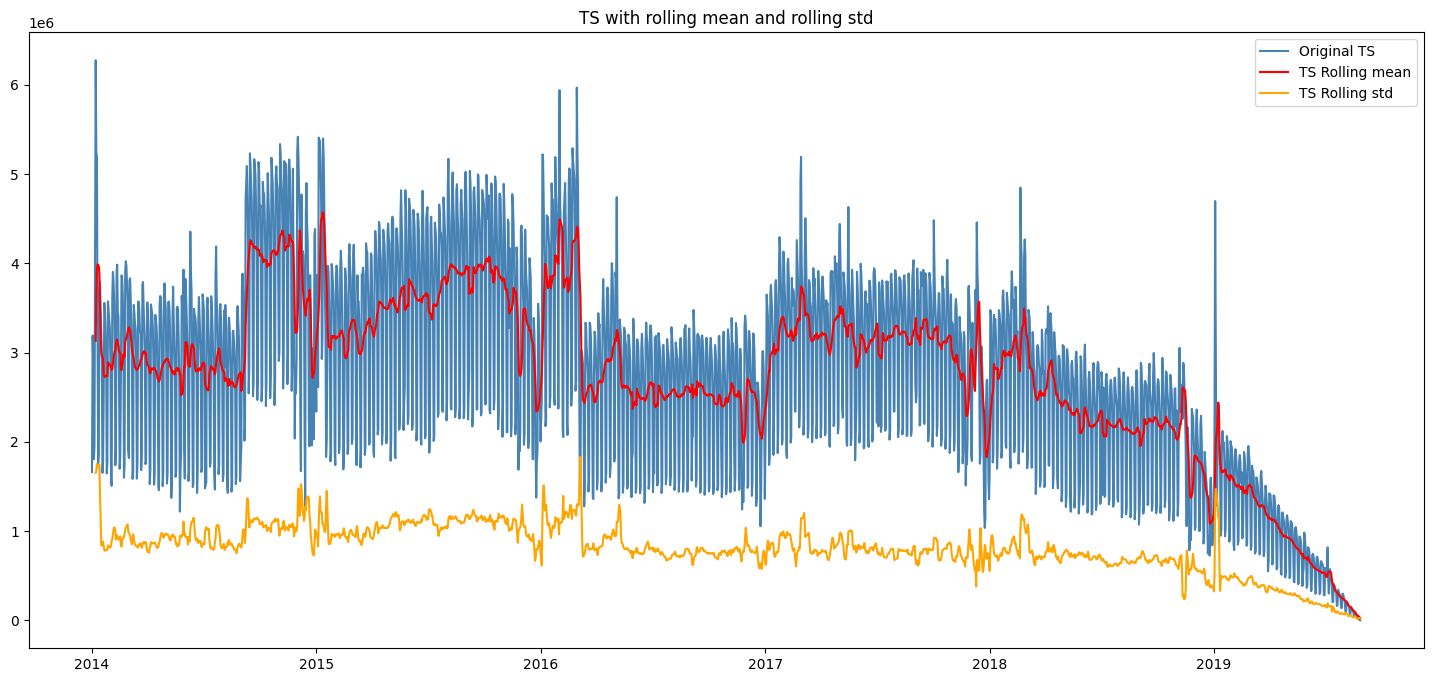

Results of the Augmented Dickey-Fuller test
Test stat.                -0.160682
p-value                    0.943049
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [16]:
def test_stationarity(timeseries, ssn_period: int, alpha: float = 0.05):
    # calculate rolling statistics
    rol_mean = timeseries.rolling(window=ssn_period).mean()
    rol_std = timeseries.rolling(window=ssn_period).std()
    
    # plot the ts and rolling metrics
    fig = plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='steelblue', label='Original TS')
    plt.plot(rol_mean, color='red', label='TS Rolling mean')
    plt.plot(rol_std, color='orange', label='TS Rolling std')
    plt.legend(loc='best')
    plt.title("TS with rolling mean and rolling std")
    plt.show()

    print("Results of the Augmented Dickey-Fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test stat.', 'p-value', '#Lags chosen', 'Total # observations'])
    print(dfoutput)
    if dfoutput['p-value'] > alpha:
        print("Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.")
    else:
        print("Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.")
    

test_stationarity(df_total['Sessions'], 7, 0.05)  

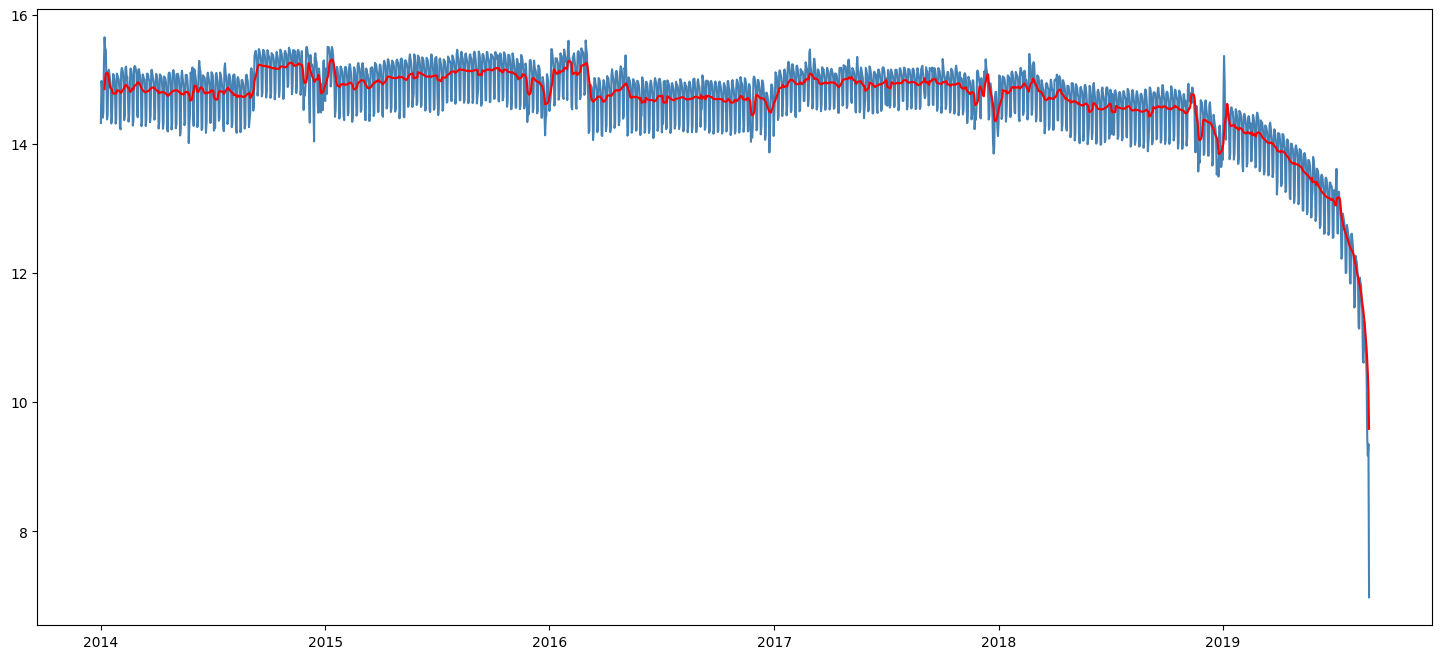

In [17]:
df_total_log = np.log(df_total)

moving_avg = df_total_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_total_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [18]:
# df_total_log.tail(50)

In [19]:
df_total_log = df_total_log[df_total_log.index <= '2018-10-01']

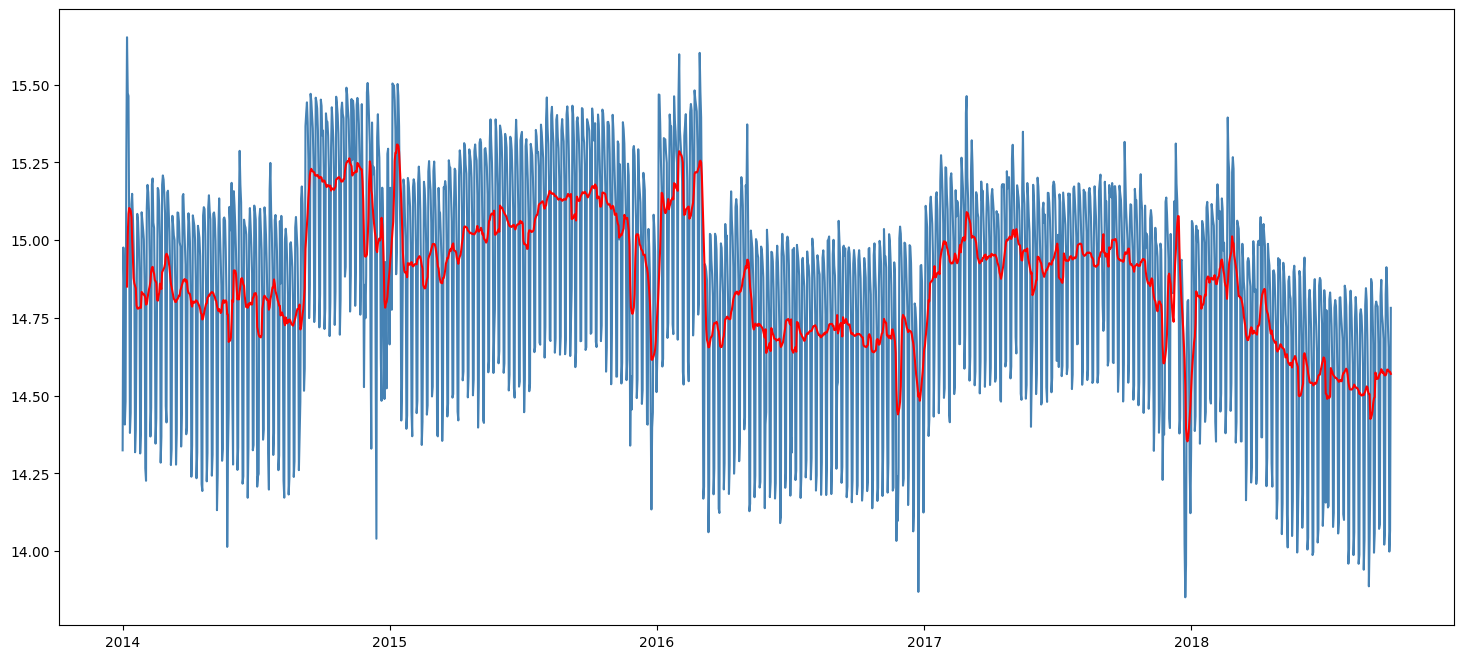

In [20]:
moving_avg = df_total_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_total_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [21]:
df_total_log_moving_mean_diff = df_total_log - moving_avg

df_total_log_moving_mean_diff.dropna(inplace=True)

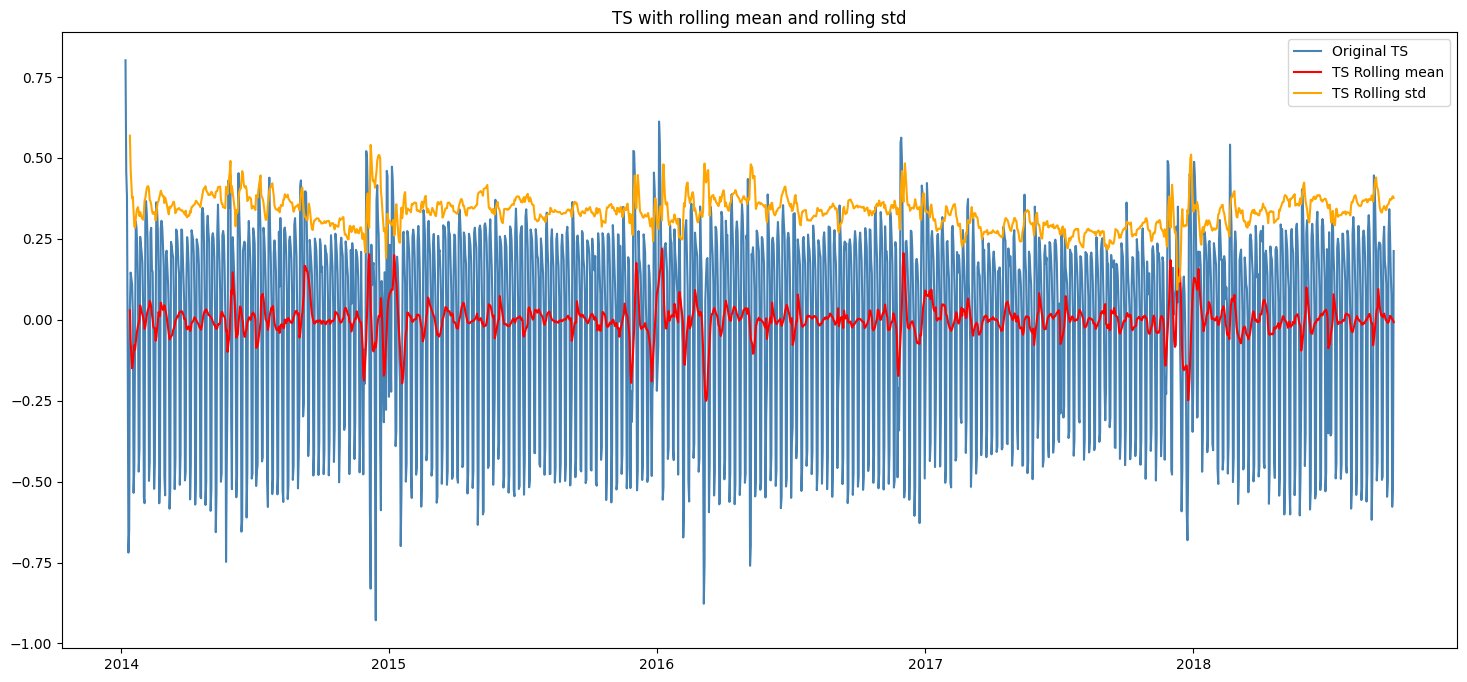

Results of the Augmented Dickey-Fuller test
Test stat.             -1.248396e+01
p-value                 3.047769e-23
#Lags chosen            2.300000e+01
Total # observations    1.705000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [22]:
test_stationarity(df_total_log_moving_mean_diff, 7, 0.05)

In [23]:
# Saving the cleaned dataset for Time Series Forecasting

df_total_log.to_csv('df_total_final.csv')

## Stationarity Test:  
The initial stationarity test failed, so I applied a logarithmic transformation and performed additional steps to make the data stationary.  

Despite these transformations, the stationarity test failed again. I hypothesized that the sharp drop in values during the last year (2019) could be causing the issue, as they appeared anomalous and potentially unrealistic. Given the size of the dataset, I opted to remove these values to improve the quality of the forecast.  

After removing the 2019 data, the dataset successfully passed the stationarity test and is now prepared for time series forecasting using ARIMA, SARIMA, and PROPHET models.  

I am saving the cleaned dataset to train the models in separate notebooks.